In [10]:
from dataloader.dataloader import CellNucleiDataset

In [11]:
from __future__ import annotations
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, Resize

In [12]:
CURRENT_DIR = os.path.dirname(os.path.abspath("__file__"))

dataset = CellNucleiDataset.create(
    target_size=(1024, 1360),  # biggest image in the dataset
    transform=ToTensor(),
    train=True,
)

Loading 42 training images


In [13]:
x, y = next(iter(dataset))

x.shape, y.shape

(torch.Size([1, 1024, 1360]), torch.Size([1024, 1360]))

## Plot X and y from the dataset

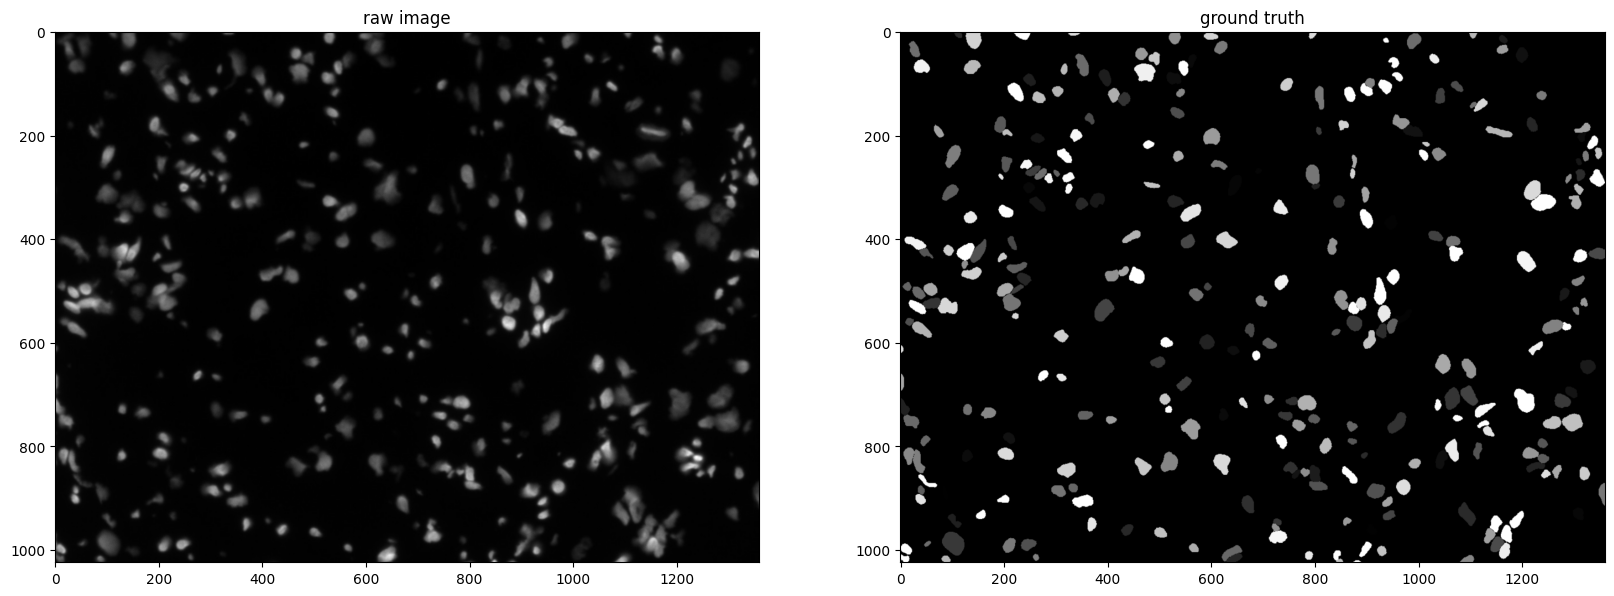

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(np.array(x)[0], cmap="gray")
axes[0].set_title("raw image")

axes[1].imshow(np.array(y), cmap="gray")
axes[1].set_title("ground truth")

plt.show()

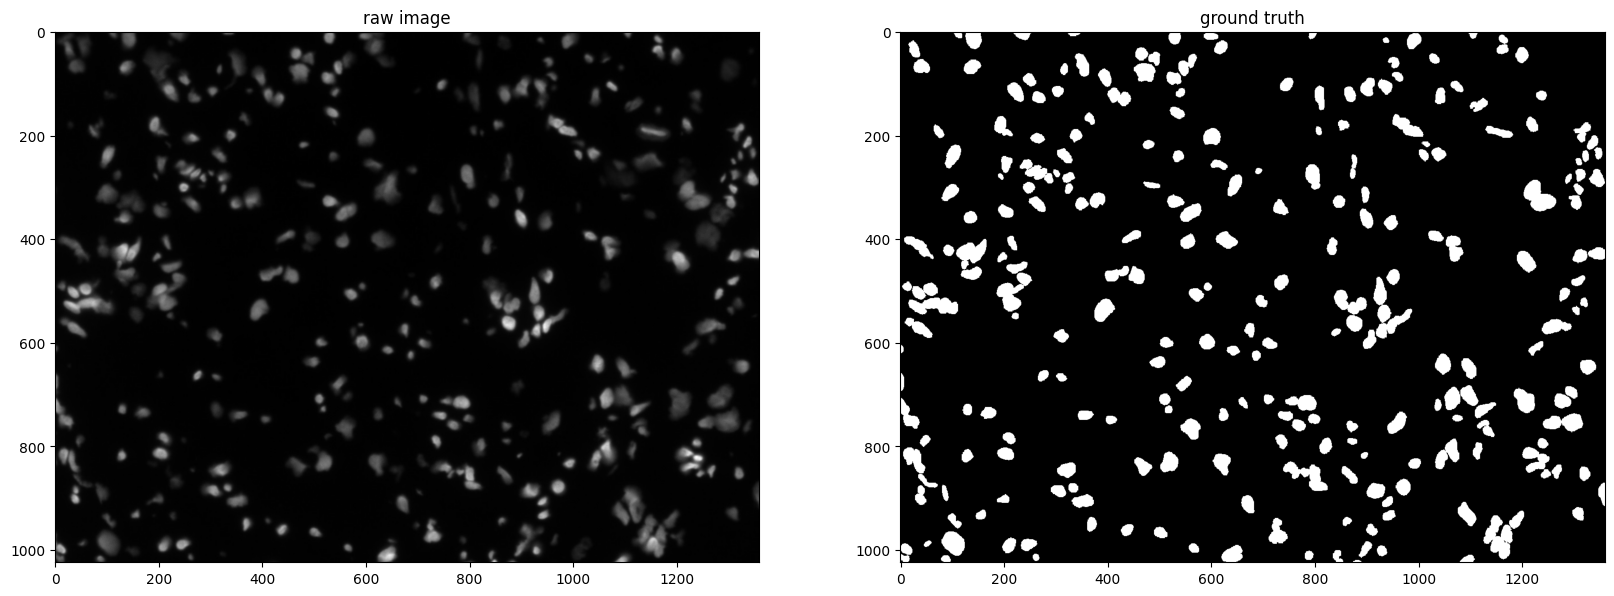

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

axes[0].imshow(np.array(x)[0], cmap="gray")
axes[0].set_title("raw image")

axes[1].imshow(np.array(y) > 0, cmap="gray")
axes[1].set_title("ground truth")

plt.show()

## Visualize clusters with numbers

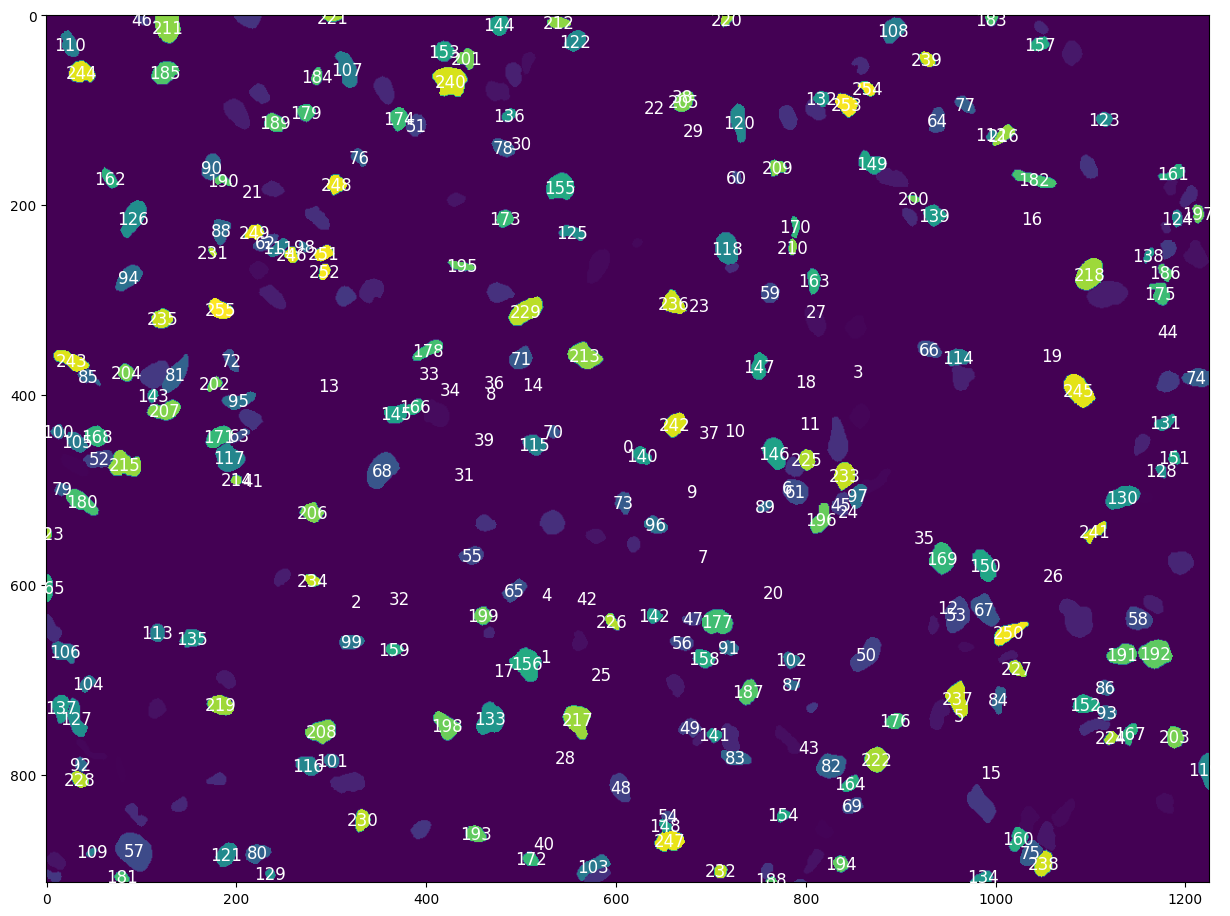

In [24]:
# Load the image as a numpy array
y = np.array(
    Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', 'Ganglioneuroblastoma_0.tif')), 
    dtype=np.uint8
)

# Get the unique cluster labels
clusters = np.unique(y)

# Plot the image with colors assigned to each cluster
plt.figure(figsize=(15, 15))
plt.imshow(y, vmin=0, vmax=len(clusters)-1)

# Add cluster numbers as text annotations
for cluster in clusters:
    # Find the coordinates of the cluster label
    cluster_coords = np.where(y == cluster)

    # Compute the centroid of the cluster
    centroid = np.mean(cluster_coords, axis=1)

    # Add the cluster number as text annotation at the centroid
    plt.text(centroid[1], centroid[0], str(cluster), color='white', fontsize=12,
             horizontalalignment='center', verticalalignment='center')


plt.show()

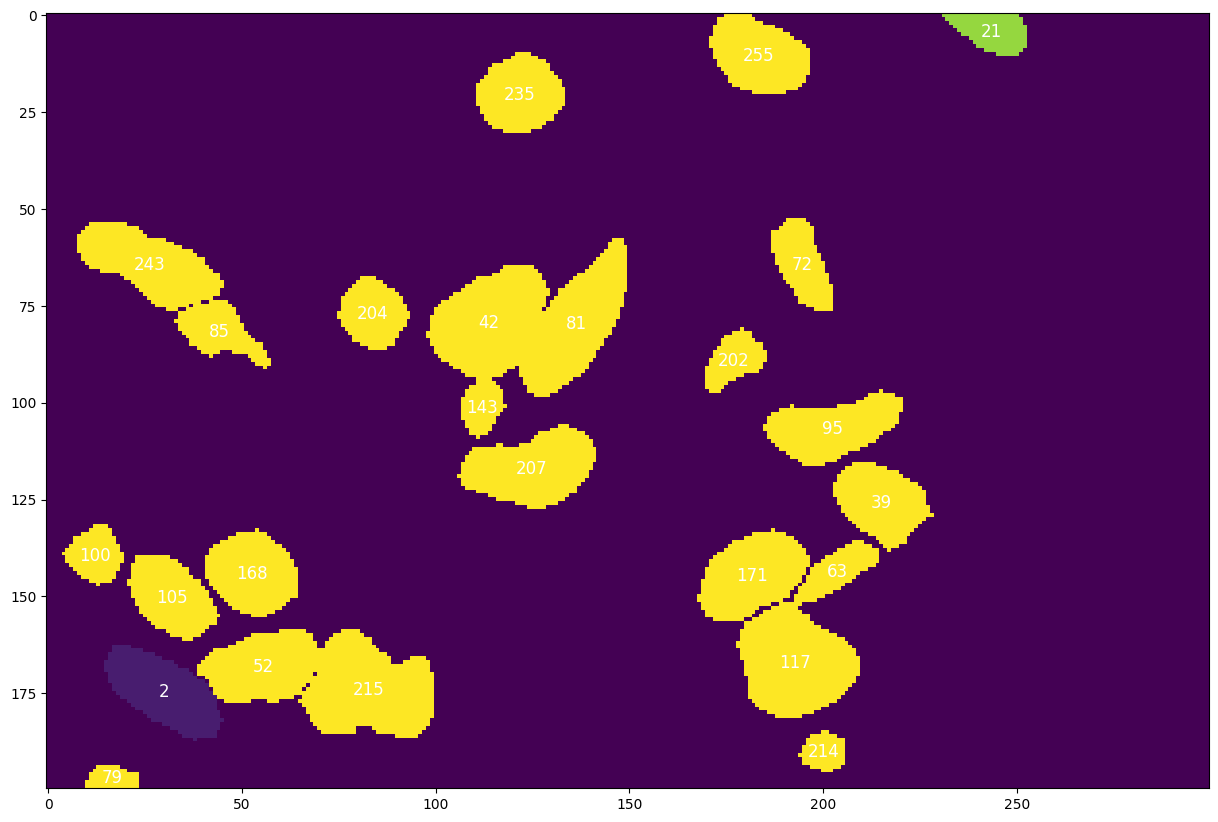

In [26]:
# Load the image as a numpy array
y = np.array(
    Image.open(os.path.join(CURRENT_DIR, '..', 'dataset', 'groundtruth', 'Ganglioneuroblastoma_0.tif')), 
    dtype=np.uint8
)

y = y[300:500, 0:300]
# Get the unique cluster labels
clusters = np.unique(y)

# Plot the image with colors assigned to each cluster
plt.figure(figsize=(15, 15))
plt.imshow(y, vmin=0, vmax=len(clusters)-1)

# Add cluster numbers as text annotations
for cluster in clusters:
    if cluster == 0:
        continue
    # Find the coordinates of the cluster label
    cluster_coords = np.where(y == cluster)

    # Compute the centroid of the cluster
    centroid = np.mean(cluster_coords, axis=1)

    # Add the cluster number as text annotation at the centroid
    plt.text(centroid[1], centroid[0], str(cluster), color='white', fontsize=12,
             horizontalalignment='center', verticalalignment='center')

plt.show()

## Augmentations

HorizontalFlip and VerticalFlip: These transformations will provide variations of the cells from different orientations.

Rotate: This can help the model to learn to recognize cells at different angles. However, be cautious with the degree of rotation. A full 360-degree rotation is usually not necessary because cells are often roughly symmetrical.

ShiftScaleRotate: This is a combination of random shifting, scaling, and rotation of the images, which can provide more variability in the training data.

ElasticTransform: This can simulate the deformable nature of biological tissues.

GaussNoise and GaussianBlur: These can help simulate variations in imaging conditions, such as focus and noise.

CLAHE (Contrast Limited Adaptive Histogram Equalization): This can help to improve the contrast of the cell images, potentially making it easier for the model to identify the cells.



In [104]:
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, 
    RandomGamma, ElasticTransform, GridDistortion, OpticalDistortion, ShiftScaleRotate, 
    HueSaturationValue, GaussNoise, GaussianBlur, CLAHE
)

def get_augmentations():
    return Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=45, p=0.3),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.3),
        ElasticTransform(p=0.3),
        GaussianBlur(sigma_limit=(1, 3), blur_limit=(1, 3), p=0.2),
    ])

dataset = CellNucleiDataset.create(
    target_size=(1024, 1360),  # biggest image in the dataset
    transform=ToTensor(),
    train=True,
)

Loading 42 training images


In [105]:
x, y = next(iter(dataset))

x.shape, y.shape

(torch.Size([1, 1024, 1360]), torch.Size([1024, 1360]))

In [106]:
a = get_augmentations()

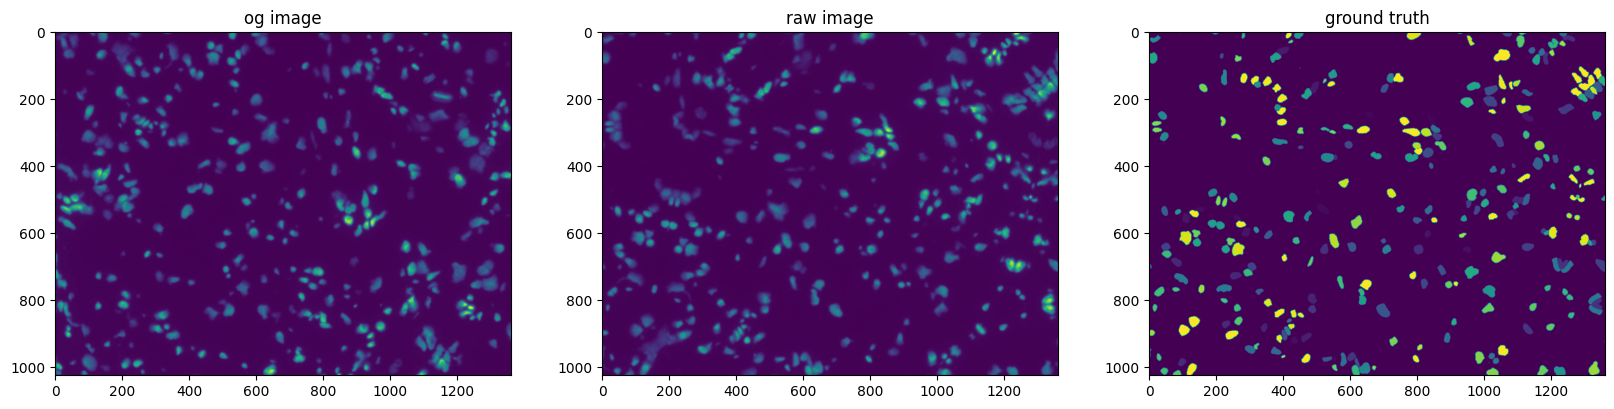

In [126]:
aug = a(image=x.numpy()[0], mask=y.numpy())
img = aug["image"]
mask = aug["mask"]

fig, axes = plt.subplots(1, 3, figsize=(20, 20))

axes[0].imshow(x[0])
axes[0].set_title("og image")

axes[1].imshow(img)
axes[1].set_title("raw image")

axes[2].imshow(mask)
axes[2].set_title("ground truth")

plt.show()